In [15]:
import json
from shapely.geometry import shape, mapping, box, Polygon, LineString, Point
from shapely.ops import unary_union
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import random

In [16]:
def meters_to_degrees(meters):
    return meters / 111320 # Перевод метров в градусы

def format_func(value, index):
    return f"{value:.5f}"  # Форматирование до 6 знаков после запятой

In [17]:
# Пример входных данных
input_geojson = {
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "properties": {"name": "Зона застройки"},
            "geometry": {
                "type": "Polygon",
                "coordinates": [[[37.6173, 55.7558],
                                 [37.6179, 55.7565],
                                 [37.6185, 55.7559],
                                 [37.6173, 55.7558]]]
            }
        },
        {
            "type": "Feature",
            "properties": {"name": "Лесная зона", "restriction": "no_build"},
            "geometry": {
                "type": "Polygon",
                "coordinates": [[[37.6180, 55.7560],
                                 [37.6185, 55.7565],
                                 [37.6190, 55.7560],
                                 [37.6180, 55.7560]]]
            }
        },
        {
            "type": "Feature",
            "properties": {"name": "Дорога", "restriction": "no_build"},
            "geometry": {
                "type": "LineString",
                "coordinates": [[37.6175, 55.7555],
                                [37.6185, 55.7555]]
            }
        }
    ]
}

In [18]:
# Определение зон застройки и зон с ограничением
build_zone = []
no_build_zone = {"name":[], "geom":[]}

for feature in input_geojson["features"]:
    geometry = shape(feature["geometry"])
    properties = feature["properties"]
    # Зоны застройки
    if properties.get("name") == "Зона застройки":
        build_zone.append(geometry)
    # Зоны с ограничем на застройку
    if properties.get("restriction") == "no_build":
        no_build_zone["geom"].append(geometry)
        no_build_zone["name"].append(properties.get("name"))

if build_zone == []:
    raise ValueError("Зоны застройки не найдены")
elif len(build_zone) > 1:
    build_zone = unary_union(build_zone)
else:
    build_zone = build_zone[0]

In [19]:
# Вычисление допустимой для застройки территории. Вычитаем из зоны застройки все области с ограничением
buildable_zone = build_zone.difference(unary_union(no_build_zone["geom"]).buffer(0))  # buffer(0) для устранения возможных ошибок геометрии

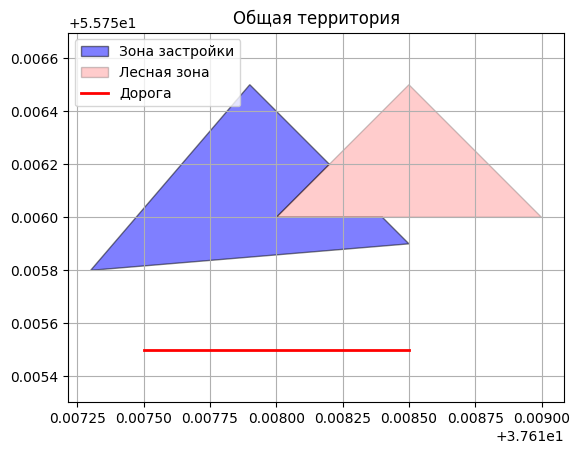

In [20]:
# Получившийся пример
x, y = buildable_zone.exterior.xy
plt.fill(x, y, alpha=0.5, fc='blue', ec='black', label="Зона застройки")

for index, geom in enumerate(no_build_zone["geom"]):
    if geom.geom_type == "Polygon":
        x, y = geom.exterior.xy
        plt.fill(x, y, alpha=0.2, fc='red', ec='black', label=no_build_zone["name"][index])
        
    elif geom.geom_type == "LineString":
        x, y = geom.coords.xy
        plt.plot(x, y, color="red", linewidth=2, label=no_build_zone["name"][index])

plt.title("Общая территория")
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()

In [21]:
# Параметры объектов (здания) 
# Задаём максимальную долю застроенной территории (например, 75%)
max_build_fraction = 0.75
# Задаём параметры для различных типов объектов
object_types = {
    'commercial': {
        'width': 3,       
        'height': 3,      
        'distance': 1
    },
    'residential': {
        'width': 3,
        'height': 3,
        'distance': 1
    },
    'park': {
        'width': 15,        
        'height': 10,       
        'distance': 1
    }
}

In [ ]:
# 1. Для каждого типа объектов алгоритм генерирует сетку таких объектов с шагов distance и заданными параметрами длины и ширины. 
# 2. Далее, все объекты не содержащиеся в зоне застройки удаляются
# 3. Все объекты добавляются в один список, в котором объекты случайным образом перемешиваются. 
# 4. Из списка достается по одному объекту и проверяются следующие условия: 
#   а) при добавлении объекта общая застроенная площадь не должна превышать заданной доли [max_build_fraction в ячейке выше]
#   б) с уже отобранными объектами не должно возникать конфликтов, связанных с минимальным расстоянием
#    При соблюдении этих условйи объект из общего списка добавляется в список отобранных объектов.
#
# За счет пункта 3 при каждом запуске двух ячеек снизу генерируется разная застройка, можно дописать код изменив способы семплирования объектов,
# что даст возможность для регулирования среднего количества каждого типа объекта.
# Возможно задавать разные параметры для каждого типа (ширниу, длину, минимальную дистанцию до других объектов)
# Сама зона застройки может быть любого типа, т.к. в ячейке сверху проверяются пересечения с зонами, ограниченными для застройки

In [59]:
# Список для кандидатов (кортежи: (тип, геометрия))
placed_objects = []

minx, miny, maxx, maxy = buildable_zone.bounds

# Для каждого типа объектов генерируем кандидатов по всему bounding box
for obj_type, params in object_types.items():
    # Переводим базовые размеры и минимальное расстояние в градусы
    width = meters_to_degrees(params['width'])
    height = meters_to_degrees(params['height'])
    min_distance = meters_to_degrees(params['distance'])

    # Определяем шаг сетки на основе среднего размера и минимального расстояния.
    # Здесь берем базовый размер (без вариации) для шага.
    grid_step_x = width + min_distance
    grid_step_y = height + min_distance
    
    # Проходим по bounding box зоны застройки
    x = minx
    while x < maxx:
        y = miny
        while y < maxy:            
            candidate = box(x, y, x + width, y + height)
            # Принимаем кандидата, если он полностью входит в buildable_zone
            if buildable_zone.contains(candidate):
                placed_objects.append((obj_type, candidate))
            y += grid_step_y
        x += grid_step_x

# Далее отбираем из кандидатов те, которые будут размещены, с учетом двух ограничений:
# 1. Суммарная площадь выбранных объектов не должна превышать max_build_fraction * buildable_zone.area
# 2. Между объектами должно расстояние должно быть не менее min_distance (для всех типов может быть разным)
random.shuffle(placed_objects)  # перемешиваем для случайного порядка
selected_objects = [] # Конечный список с "случайно" отобранными объектами
total_built_area = 0.0 # Накполенная площадь от включения в список объектов
max_total_area = buildable_zone.area * max_build_fraction # Максимальная площадь объектов, зависящая от плотности застройки

for obj_type, candidate in placed_objects:
    min_distance_candidate = meters_to_degrees(object_types[obj_type]["distance"]) # У каждого типа может быть свое минимальное расстояние
    # Проверка: если добавление этого объекта превысит лимит по суммарной площади – пропускаем
    if total_built_area + candidate.area < max_total_area:
        # Проверка минимального расстояния: кандидат не должен быть ближе, чем min_distance_candidate к остальным объектам
        conflict = False
        for other_type, other_object in selected_objects:
            distance = candidate.distance(other_object)
            min_distance_other = meters_to_degrees(object_types[other_type]["distance"])
            # На 0.99 умножается из-за потерь в float32, т.к. код может отрабатывать неккоректно
            if distance < min_distance_candidate * 0.99 or distance < min_distance_other * 0.99:
                conflict = True
                break
            else:
                continue
        if not conflict:
            # Если все проверки пройдены – добавляем кандидат в итоговый список
            selected_objects.append((obj_type, candidate))
            total_built_area += candidate.area
    else:
        print("check")
        continue

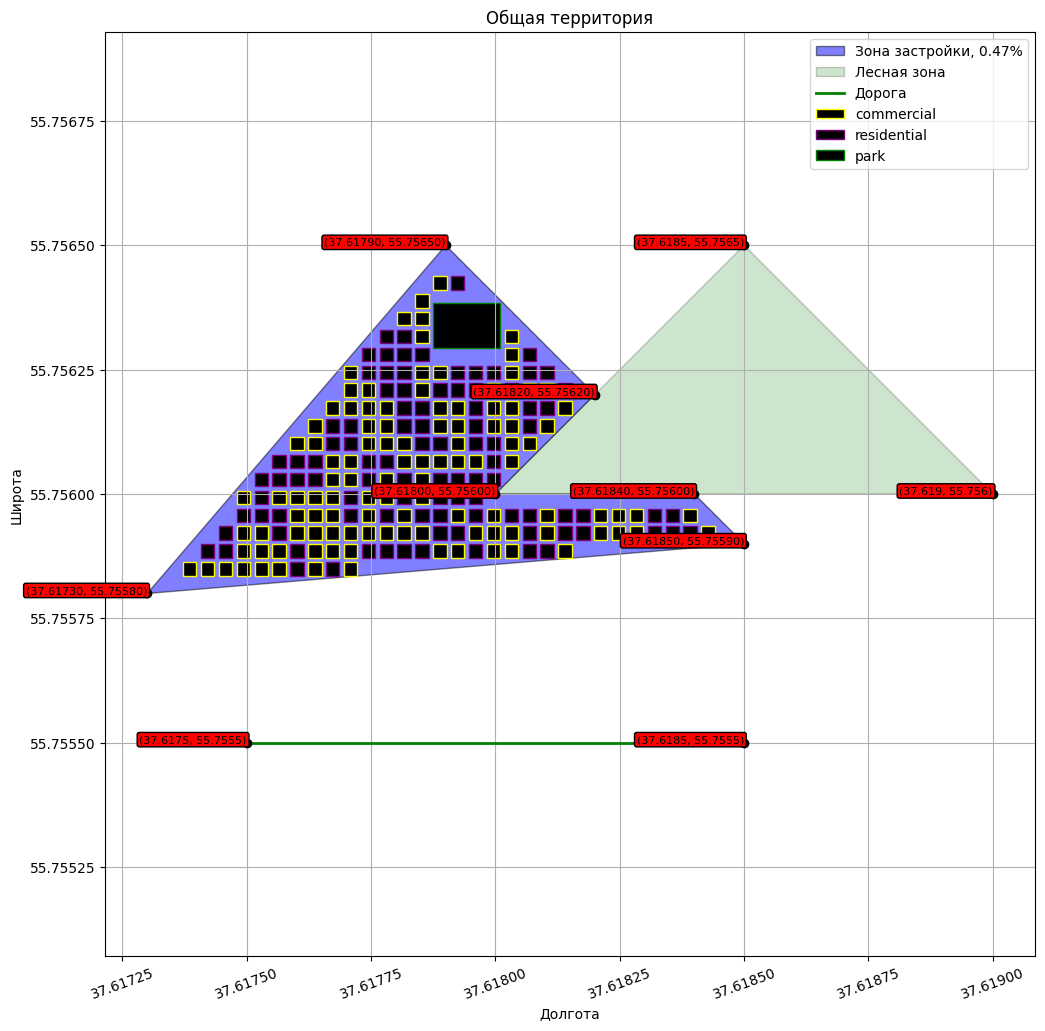

In [83]:
all_points = []
# Зона застройки
plt.figure(figsize=(12, 12))
x, y = buildable_zone.exterior.xy
area_building = sum(selected_objects[index][1].area for index in range(len(selected_objects))) / buildable_zone.area # Процент застроенной площади
plt.fill(x, y, alpha=0.5, fc='blue', ec='black', label=f"Зона застройки, {round(area_building, 2)}%")
for point in zip(x[:-1], y[:-1]):
    plt.text(point[0], point[1], f"({point[0]:.5f}, {point[1]:.5f})", fontsize=8, ha='right', 
        bbox=dict(facecolor='red', edgecolor='black', boxstyle='round,pad=0.2'))
    plt.plot(point[0], point[1], marker="o", color="black")
    all_points.append((point[0], point[1]))
# Зоны с ограничениями
for index, geom in enumerate(no_build_zone["geom"]):
    if geom.geom_type == "Polygon":
        x, y = geom.exterior.xy
        plt.fill(x, y, alpha=0.2, fc='green', ec='black', label=no_build_zone["name"][index])
        for point in zip(x[:-1], y[:-1]):
            if (point[0], point[1]) not in all_points:
                plt.text(point[0], point[1], f"({point[0]}, {point[1]})", fontsize=8, ha='right', 
                    bbox=dict(facecolor='red', edgecolor='black', boxstyle='round,pad=0.2'))
                plt.plot(point[0], point[1], marker="o", color="black")
    elif geom.geom_type == "LineString":
        x, y = geom.coords.xy
        plt.plot(x, y, color="green", linewidth=2, label=no_build_zone["name"][index])
        for point in zip(x, y):
            if (point[0], point[1]) not in all_points:
                plt.text(point[0], point[1], f"({point[0]}, {point[1]})", fontsize=8, ha='right', 
                    bbox=dict(facecolor='red', edgecolor='black', boxstyle='round,pad=0.2'))
                plt.plot(point[0], point[1], marker="o", color="black")
# Объекты в зоне постройки
check_obj_type = set()
for obj_type, geom in selected_objects:
    x, y = geom.exterior.xy
    plt.fill(x, y, alpha = 1, 
                fc = 'black', 
                ec = "purple" if obj_type == "residential" else "yellow" if obj_type == "commercial" else "green", 
                label = obj_type if obj_type not in check_obj_type else "")
    check_obj_type.add(obj_type)
plt.title("Общая территория")
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.xticks(rotation=20)
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_func))
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))
plt.xlabel("Долгота")
plt.ylabel("Широта")
plt.savefig("plan.jpg", format="jpeg", dpi=500)
plt.show()

In [66]:
# Формируем итоговый GeoJSON с размещёнными объектами
features = []
for obj_type, geom in selected_objects:
    feature = {
        "type": "Feature",
        "properties": {"type": obj_type},
        "geometry": mapping(geom)
    }
    features.append(feature)

output_geojson = {
    "type": "FeatureCollection",
    "features": features
}

# Сохраняем в файл
with open("output_plan.geojson", "w", encoding="utf-8") as f:
    json.dump(output_geojson, f, ensure_ascii=False, indent=2)